In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import torch.nn as nn
import time
import pickle
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
import seaborn as sns

In [2]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import top_k_accuracy_score

In [3]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
RUN             = '1'

seeds           = {'1':5123, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div_spec_norm'


plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'


if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [6]:
torch.manual_seed(seeds[RUN])
np.random.seed(seeds[RUN])


In [7]:
decoded = {}
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)

#decoded['train'],decoded['valid'], decoded['test'], mean, std  = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)

In [8]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new_relabeled.pkl'%label_),'rb'))

In [9]:
# Sampler = Samplers[upsampling]
# unique, counts = np.unique(df_train['new_subclass'], return_counts=True)
# print(counts)
# min_counts = np.amin(counts)
# print(min_counts)
# sampling_strategy = {0: max(counts[0],min_counts*fac), 1:max(counts[1],min_counts*fac), 2: max(counts[2],min_counts*fac), 3: max(counts[3],min_counts*fac), 4:max(counts[4],min_counts*fac)\
#                      , 5:max(counts[5],min_counts*fac), 6:max(counts[6],min_counts*fac), 7:max(counts[7],min_counts*fac)}
# smt = Sampler(sampling_strategy=sampling_strategy)
# X_smt, y_smt = smt.fit_resample(encoded_train,df_train['new_subclass'])

# unique, counts = np.unique(df_valid['new_subclass'], return_counts=True)
# min_counts = np.amin(counts)
# print(min_counts)
# sampling_strategy = {0: max(counts[0],min_counts*fac), 1:max(counts[1],min_counts*fac), 2: max(counts[2],min_counts*fac), 3: max(counts[3],min_counts*fac), 4:max(counts[4],min_counts*fac)\
#                      , 5:max(counts[5],min_counts*fac), 6:max(counts[6],min_counts*fac), 7:max(counts[7],min_counts*fac)}
# smt = Sampler(sampling_strategy=sampling_strategy)
# X_smt_v, y_smt_v = smt.fit_resample(encoded_valid,df_valid['new_subclass'])

In [10]:
# np.unique(y_smt, return_counts=True), np.unique(y_smt_v, return_counts=True)

In [11]:
train_x = torch.Tensor(encoded_train).to(device) 
train_y = torch.Tensor(train['new_label']).to(torch.long).to(device)

valid_x = torch.Tensor(encoded_valid).to(device) 
valid_y = torch.Tensor(valid['new_label']).to(torch.long).to(device)

test_x = torch.Tensor(encoded_test).to(device) 
test_y = torch.Tensor(test['new_label']).to(torch.long).to(device)

In [12]:
def _conditional_transform_batch_model(model, data, label, logj, index, batchsize, start_index=0, end_index=None, start=0, end=None, param=None, nocuda=False):

    if torch.cuda.is_available() and not nocuda:
        gpu    = index % torch.cuda.device_count()
        device = torch.device('cuda:%d'%gpu)
    else:
        device = torch.device('cpu')

    model = model.to(device)

    if end_index is None:
        end_index = len(data)

    i = 0
    while i * batchsize < end_index-start_index:
        start_index0 = start_index + i * batchsize 
        end_index0 = min(start_index + (i+1) * batchsize, end_index) 
        if param is None:
            data1, logj1 = model.transform(data[start_index0:end_index0].to(device), label[start_index0:end_index0].to(device), start=start, end=end, param=param)
        else:
            data1, logj1 = model.transform(data[start_index0:end_index0].to(device), label[start_index0:end_index0].to(device), start=start, end=end, param=param[start_index0:end_index0].to(device))
        data[start_index0:end_index0] = data1.to(data.device)
        logj[start_index0:end_index0] = logj[start_index0:end_index0] + logj1.to(logj.device)
        i += 1

    del data1, logj1, model 
    if torch.cuda.is_available() and not nocuda:
        torch.cuda.empty_cache()

    return


def conditional_transform_batch_model(model, data, label, batchsize, logj=None, start=0, end=None, param=None, pool=None, nocuda=False):

    if logj is None:
        logj = torch.zeros(len(data), device=data.device)

    if pool is None: 
        _transform_batch_model(model, data, label, logj, 0, batchsize, start=start, end=end, param=param, nocuda=nocuda) 
    else:
        if torch.cuda.is_available() and not nocuda:
            nprocess = torch.cuda.device_count()
        else:
            nprocess = mp.cpu_count()
        param0 = [(model, data, label, logj, i, batchsize, len(data)*i//nprocess, len(data)*(i+1)//nprocess, start, end, param, nocuda) for i in range(nprocess)]
        pool.starmap(_conditional_transform_batch_model, param0)

    return data, logj


def _conditional_transform_batch_layer(layer, data, label, logj, index, batchsize, start_index=0, end_index=None, direction='forward', param=None, nocuda=False):

    if torch.cuda.is_available() and not nocuda:
        gpu = index % torch.cuda.device_count()
        device = torch.device('cuda:%d'%gpu)
    else:
        device = torch.device('cpu')
    
    layer = layer.to(device)

    if end_index is None:
        end_index = len(data)

    i = 0
    while i * batchsize < end_index-start_index:
        start_index0 = start_index + i * batchsize 
        end_index0 = min(start_index + (i+1) * batchsize, end_index) 
        if direction == 'forward': 
            if param is None:
                data1, logj1 = layer.forward(data[start_index0:end_index0].to(device),label[start_index0:end_index0].to(device), param=param)
            else:
                data1, logj1 = layer.forward(data[start_index0:end_index0].to(device), label[start_index0:end_index0].to(device), param=param[start_index0:end_index0].to(device))
        else: 
            if param is None:
                data1, logj1 = layer.inverse(data[start_index0:end_index0].to(device),label[start_index0:end_index0].to(device), param=param)
            else:
                data1, logj1 = layer.inverse(data[start_index0:end_index0].to(device),label[start_index0:end_index0].to(device), param=param[start_index0:end_index0].to(device))
        data[start_index0:end_index0] = data1.to(data.device)
        logj[start_index0:end_index0] = logj[start_index0:end_index0] + logj1.to(logj.device)
        i += 1

    del data1, logj1, layer 
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return


def conditional_transform_batch_layer(layer, data, label, batchsize, logj=None, direction='forward', param=None, pool=None, nocuda=False):
    assert direction in ['forward', 'inverse']
    
    if logj is None:
        logj = torch.zeros(len(data), device=data.device)
    
    if pool is None: 
        _conditional_transform_batch_layer(layer, data, label, logj, 0, batchsize, direction=direction, param=param, nocuda=nocuda) 
    else:
        if torch.cuda.is_available() and not nocuda:
            nprocess = torch.cuda.device_count()
        else:
            nprocess = mp.cpu_count()
        param0 = [(layer, data, label, logj, i, batchsize, len(data)*i//nprocess, len(data)*(i+1)//nprocess, direction, param, nocuda) for i in range(nprocess)]
        pool.starmap(_conditional_transform_batch_layer, param0)
    
    return data, logj


In [13]:
class ConditionalSINF(nn.Module):

    #Sliced Iterative Normalizing Flow model
    
    def __init__(self, ndim, n_class):
        
        super().__init__()
        
        self.layer = nn.ModuleList([])
        self.ndim = ndim
        self.n_class = n_class
    
    def forward(self, data, label, start=0, end=None):
        
        if data.ndim == 1:
            data = data.view(1,-1)
        if end is None:
            end = len(self.layer)
        elif end < 0:
            end += len(self.layer)
        if start < 0:
            start += len(self.layer)
        
        assert start >= 0 and end >= 0 and end >= start

        logj = torch.zeros(data.shape[0], device=data.device)
        
        for i in range(start, end):
            data, log_j = self.layer[i](data, param=label)
            logj += log_j

        return data, logj
    
    
    def inverse(self, data, label, start=None, end=0, d_dz=None):

        if data.ndim == 1:
            data = data.view(1,-1)
        if end < 0:
            end += len(self.layer)
        if start is None:
            start = len(self.layer)
        elif start < 0:
            start += len(self.layer)
        
        assert start >= 0 and end >= 0 and end <= start

        logj = torch.zeros(data.shape[0], device=data.device)
        
        for i in reversed(range(end, start)):
            if d_dz is None:
                data, log_j = self.layer[i].inverse(data, param=label)
            else:
                data, log_j, d_dz = self.layer[i].inverse(data,d_dz=d_dz, param=label)
            logj += log_j

        if d_dz is None:
            return data, logj
        else:
            return data, logj, d_dz


    def transform(self, data, label, start, end,):

        if start is None:
            return self.inverse(data=data, start=start, end=end, param=label) 
        elif end is None:
            return self.forward(data=data, start=start, end=end, param=label) 
        elif start < 0:
            start += len(self.layer)
        elif end < 0:
            end += len(self.layer)
        
        if start < 0:
            start = 0
        elif start > len(self.layer):
            start = len(self.layer)
        if end < 0:
            end = 0
        elif end > len(self.layer):
            end = len(self.layer)

        if start <= end:
            return self.forward(data=data, start=start, end=end, param=label) 
        else:
            return self.inverse(data=data, start=start, end=end, param=label) 
    
    
    def add_layer(self, layer, position=None):
        
        if position is None or position == len(self.layer):
            self.layer.append(layer)
        else:
            if position < 0:
                position += len(self.layer)
            assert position >= 0 and position < len(self.layer)
            self.layer.insert(position, layer)
        
        return self
    
    
    def delete_layer(self, position=-1):
        
        if position == -1 or position == len(self.layer)-1:
            self.layer = self.layer[:-1]
        else:
            if position < 0:
                position += len(self.layer)
            assert position >= 0 and position < len(self.layer)-1
            
            for i in range(position, len(self.layer)-1):
                self.layer._modules[str(i)] = self.layer._modules[str(i + 1)]
            self.layer = self.layer[:-1]
        
        return self
    
    
    def evaluate_density(self, data, label, start=0, end=None):
        
        data, logj = self.forward(data, label, start=start, end=end)
        logq = -self.ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.sum(data.reshape(len(data), self.ndim)**2,  dim=1)/2
        logp = logj + logq
        
        return logp


    def loss(self, data, start=0, end=None, param=None):
        return -torch.mean(self.evaluate_density(data, label, start=start, end=end, param=param))
    
    
    def sample(self, nsample, start=None, end=0, device=torch.device('cuda'), param=None):

        #device must be the same as the device of the model
        
        x       = torch.randn(nsample, self.ndim, device=device)
        logq    = -self.ndim/2.*torch.log(torch.tensor(2.*math.pi)) - torch.sum(x**2,  dim=1)/2
        x, logj = self.inverse(x, start=start, end=end, param=param)
        logp    = logj + logq

        return x, logp


    def score(self, data, label, start=0, end=None, param=None):

        #returns score = dlogp / dx

        data.requires_grad_(True)
        logp  = torch.sum(self.evaluate_density(data, label, start, end, param))
        score = torch.autograd.grad(logp, data)[0]
        data.requires_grad_(False)

        return score

In [14]:
def train_ConditionalGIS(data_train, label_train, data_valid, label_valid, iteration=None, K=None, M=None, KDE=True, b_factor=1, alpha=None, bounds=None,max_iter=400,
        edge_bins=None, ndata_A=None, MSWD_max_iter=None, NBfirstlayer=False, Whiten=True, batchsize=None, nocuda=False, patch=False, shape=None, model=None, verbose=True):
    
    '''
    data_train: (ndata_train, ndim).
    data_valid: (ndata_valid, ndim), optional. If provided, its logp will be used to determine the number of iterations.
    iteration: integer, optional. The maximum number of GIS iterations. Required if data_valid is not provided.
    K: integer, optional. The number of slices for each iteration. See max K-SWD in the SINF paper. 1 <= K <= ndim.
    M: integer, optional. The number of spline knots for rational quadratic splines.
    KDE: bool. Whether to use KDE for estimating 1D PDF. Recommended True.
    b_factor: positive float number, optional. The multiplicative factor for KDE kernel width.
    alpha: two non-negative float number in the format of (alpha1, alpha2), optional. Regularization parameter. See Equation 13 of SINF paper. alpha1 for interpolation, alpha2 for extrapolation slope. 0 <= alpha1,2 < 1. If not given, very heavy regularization will be used, which could result in slow training and a large number of iterations.
    bounds: sequence, optional. In the format of [[x1_min, x1_max], [x2_min, x2_max], ..., [xd_min, xd_max]]. Represent infinity and negative infinity with None.
    edge_bins: non-negative integer, optional. The number of spline knots at the boundary.
    ndata_A: positive integer, optional. The number of training data used for fitting A (slice axes).
    MSWD_max_iter: positive integer, optional. The maximum number of iterations for optimizing A (slice axes). See Algorithm 1 of SINF paper. Called L_iter in the paper.
    NBfirstlayer: bool, optional. Whether to use Naive Bayes (no rotation) at the first layer.
    Whiten: bool, optional. Whether to whiten the data before applying GIS.
    batchsize: positive integer, optional. The batch size for transforming the data. Does not change the performance. Only saves the memory. 
    Useful when the data is too large and can't fit in the memory.
    nocuda: bool, optional. Whether to use gpu.
    patch: bool, optional. Whether to use patch-based modeling. Only useful for image datasets.
    shape: sequence, optional. The shape of the image datasets, if patch is enabled.
    model: GIS model, optional. Trained GIS model. If provided, new iterations will be added in the model.
    verbose: bool, optional. Whether to print training information.
    '''

    assert data_valid is not None or iteration is not None
 
    #hyperparameters
    ndim    = data_train.shape[1]
    nclass  = len(np.unique(label_train.cpu().numpy()))
    print(ndim,nclass)

    ndata = len(data_train)

    if M is None:
        M = max(min(200, int(ndata**0.5)), 50)
    if alpha is None:
        alpha = (1-0.02*math.log10(ndata), 1-0.001*math.log10(ndata))#).to(device)
    if bounds is not None:
        assert len(bounds) == ndim
        for i in range(ndim):
            assert len(bounds[i]) == 2
    if edge_bins is None:
        edge_bins = max(int(math.log10(ndata))-1, 0)
    if batchsize is None:
        batchsize = len(data_train)
    if not patch:
        if K is None:
            if ndim <= 8 or ndata / float(ndim) < 20:
                K = ndim
            else:
                K = 8
        if ndata_A is None:
            ndata_A = min(len(data_train), int(math.log10(ndim)*1e5))
        if MSWD_max_iter is None:
            MSWD_max_iter = min(round(ndata) // ndim, 200)
    else:
        assert shape[0] > 4 and shape[1] > 4
        K0 = K
        ndata_A0 = ndata_A
        MSWD_max_iter0 = MSWD_max_iter

        
    best_accuracy = 0
    #device
    device = torch.device("cuda:0" if torch.cuda.is_available() and not nocuda else "cpu")

    
    ### taking out logit transform and replacing log jacobian with zeros 
    logj_train    = torch.zeros(data_train.shape[0],device=device)
    logj_valid    = torch.zeros(data_valid.shape[0],device=device)

    #define the model
    if model is None:
        model = ConditionalSINF(ndim=ndim,n_class=nclass).requires_grad_(False).to(device)
        if data_valid is not None:
            best_logp_valid = -1e10
            best_Nlayer     = 0
            wait            = 0
            maxwait         = 5 
#     else:
#         t = time.time()
#         data_train, logj_train = conditional_transform_batch_model(model, data_train, batchsize, logj=logj_train, start=0, end=None, nocuda=nocuda)
#         logp_train             = (torch.mean(logj_train) - ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.mean(torch.sum(data_train**2,  dim=1)/2)).item()
        
#         if data_valid is not None:
#             data_valid, logj_valid = conditional_transform_batch_model(model, data_valid, batchsize, logj=logj_valid, start=0, end=None, nocuda=nocuda)
#             logp_valid             = (torch.mean(logj_valid) - ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.mean(torch.sum(data_valid**2,  dim=1)/2)).item()
#             print ('Initial logp:', logp_train, logp_valid, 'time:', time.time()-t, 'iteration:', len(model.layer))
#         else:
#             print ('Initial logp:', logp_train, 'time:', time.time()-t, 'iteration:', len(model.layer))

    
    #whiten
    if Whiten:
        layer = whiten(ndim_data=ndim, scale=True, ndim_latent=ndim).requires_grad_(False).to(device)
        layer.fit(data_train)

        data_train, logj_train0 = layer(data_train)
        logj_train += logj_train0

        logp_train = (torch.mean(logj_train) - ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.mean(torch.sum(data_train**2,  dim=1)/2)).item()
        
        if data_valid is not None:
            data_valid, logj_valid0 = layer(data_valid)
            logj_valid += logj_valid0
            logp_valid = (torch.mean(logj_valid) - ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.mean(torch.sum(data_valid**2,  dim=1)/2)).item()
            if logp_valid > best_logp_valid:
                best_logp_valid = logp_valid
                best_Nlayer = len(model.layer)

        model.add_layer(layer)
        if verbose:
            if data_valid is not None:
                print('After whiten logp:', logp_train, logp_valid)
            else:
                print('After whiten logp:', logp_train)

                
                
    data_train    = data_train[None,:].repeat_interleave(nclass, axis=0)
    data_valid    = data_valid[None,:].repeat_interleave(nclass, axis=0)

    logj_train    = logj_train[None,:].repeat_interleave(nclass, axis=0)
    logj_valid    = logj_valid[None,:].repeat_interleave(nclass, axis=0)

    #GIS iterations
    
    ii=0
    while True:
        t = time.time()

        if NBfirstlayer:
            layer = ConditionalSlicedTransport_discrete(ndim=ndim, n_class = nclass, K=ndim, M=M).requires_grad_(False).to(device)
        else:
            layer = ConditionalSlicedTransport_discrete(ndim=ndim, n_class = nclass, K=K, M=M).requires_grad_(False).to(device)

        #fit the layer
        if NBfirstlayer:
            layer.A[:] = torch.eye(ndim).to(device)
            NBfirstlayer = False
        elif ndim > 1:
            layer.fit_A(data_train[label_train, torch.arange(data_train.shape[1]).cuda()], MSWD_max_iter=MSWD_max_iter, verbose=verbose)

        layer.fit_spline(data_train[label_train, torch.arange(data_train.shape[1]).cuda()], label_train, edge_bins=edge_bins, derivclip=1, alpha=alpha, KDE=KDE, b_factor=b_factor, verbose=False)
        
        for label in range(nclass):
            data_train[label], logj_train1 = layer(data_train[label], torch.ones(data_train.shape[1], dtype=torch.int, device=data_train.device)*label)
            logj_train[label] = logj_train[label] + logj_train1

            data_valid[label], logj_valid1 = layer(data_valid[label], torch.ones(data_valid.shape[1], dtype=torch.int, device=data_valid.device)*label)
            logj_valid[label] = logj_valid[label] + logj_valid1

        model.add_layer(layer)


#     for label in range(n_class):
#         data_train[label], logj_train1 = layer(data_train[label], torch.ones(data_train.shape[1], dtype=torch.int, device=data_train.device)*label)
#         logp_train[label]              = logj_train - torch.sum(data_train**2,  dim=1)/2- ndim/2*torch.log(torch.tensor(2*math.pi))

#         data_valid[label], logj_valid1 = layer(data_validate[label], torch.ones(data_validate.shape[1], dtype=torch.int, device=data_validate.device)*label)
#         logp_valid[label]              = logj_valid

#         data_test[label], logj_test1 = layer(data_test[label], torch.ones(data_test.shape[1], dtype=torch.int, device=data_test.device)*label)
#         logj_test[label]             = logj_test[label] + logj_test1
        
        logp_train = (torch.mean(logj_train[label_train, torch.arange(data_train.shape[1]).cuda()]) - ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.mean(torch.sum(data_train[label_train, torch.arange(data_train.shape[1]).cuda()]**2,  dim=1)/2)).item()
        logp_valid = (torch.mean(logj_valid[label_valid, torch.arange(data_valid.shape[1]).cuda()]) - ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.mean(torch.sum(data_valid[label_valid, torch.arange(data_valid.shape[1]).cuda()]**2,  dim=1)/2)).item()

        
#         logp_valid_label = torch.ones([nclass,label_valid.shape[0]], device=data_valid.device)
#         if data_valid is not None:
#             for mm in range(nclass):
#                 data_valid, logj_valid = conditional_transform_batch_layer(layer, data_valid, torch.ones(label_valid.shape, dtype=torch.int, device=data_valid.device)*mm, batchsize, logj=logj_valid, direction='forward', nocuda=nocuda)
#                 logp_valid = (logj_valid - torch.sum(data_valid**2,  dim=1)/2)- ndim/2*torch.log(torch.tensor(2*math.pi))
#                 logp_valid_label[mm] = logp_valid
#             predict_label_valid = torch.argmax(logp_valid_label,dim=0)
#             accuracy = torch.sum(predict_label_valid==label_valid).item() / len(label_valid)
#             print('valid accuracy: ', torch.sum(predict_label_valid==label_valid).item() / len(label_valid))
    
#             data_valid, logj_valid = conditional_transform_batch_layer(layer, data_valid, label_valid, batchsize, logj=logj_valid, direction='forward', nocuda=nocuda)
#             logp_valid = (torch.mean(logj_valid) - ndim/2*torch.log(torch.tensor(2*math.pi)) - torch.mean(torch.sum(data_valid**2,  dim=1)/2)).item()

            
        if logp_valid > best_logp_valid:
            best_logp_valid = logp_valid
            best_Nlayer = len(model.layer)
            wait = 0
        else:
            wait += 1
        if wait == maxwait:
            model.layer = model.layer[:best_Nlayer]
            break
        if ii>max_iter:
            break

#         if  accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_Nlayer_acc = len(model.layer)
#             wait_acc = 0
#         else:
#             wait_acc += 1
#         if wait_acc == maxwait:
#             model.layer = model.layer[:best_Nlayer_acc]
#             break

        if verbose:
            if data_valid is not None: 
                print ('logp:', logp_train, logp_valid, 'time:', time.time()-t, 'iteration:', len(model.layer), 'best:', best_Nlayer)
            else:
                print ('logp:', logp_train, 'time:', time.time()-t, 'iteration:', len(model.layer))

        if iteration is not None and len(model.layer) >= iteration:
            if data_valid is not None:
                model.layer = model.layer[:best_Nlayer]
            break
        ii+=1

    return model

In [15]:
model = train_ConditionalGIS(train_x, train_y,valid_x, valid_y)

10 16
After whiten logp: 1.6788034439086914 2.4338130950927734
Fit A: Time: 1.973940185546875 Wasserstein Distance: [1.2514286041259766, 1.2443143129348755, 1.175095796585083, 1.0580074787139893, 0.9877622723579407, 0.9352023601531982, 0.7161985635757446, 0.6887352466583252]
logp: 7.49314022064209 8.124631881713867 time: 5.821911573410034 iteration: 2 best: 2
Fit A: Time: 1.4011783447265624 Wasserstein Distance: [1.1386102437973022, 1.1223549842834473, 1.0066795349121094, 0.9834992289543152, 0.9024248719215393, 0.8999311923980713, 0.7737873196601868, 0.5224326848983765]
logp: 10.55096435546875 11.09390926361084 time: 5.218098878860474 iteration: 3 best: 3
Fit A: Time: 1.37708056640625 Wasserstein Distance: [1.04164719581604, 1.028236985206604, 0.9646772146224976, 0.8996230959892273, 0.8059335947036743, 0.7508769631385803, 0.7022202610969543, 0.4796364903450012]
logp: 12.81200122833252 13.277670860290527 time: 4.362963676452637 iteration: 4 best: 4
Fit A: Time: 0.9545675048828125 Wasser

In [30]:
torch.save(model,os.path.join(root_models,'conditional_SINF_%s_inpainted_denoised_data_relabeled'%(label_2)))

In [17]:
model=torch.load(os.path.join(root_models,'conditional_SINF_%s_inpainted_denoised_data_relabeled'%(label_2)))

In [18]:
train_x = torch.Tensor(encoded_train).to(device) 
train_y = torch.Tensor(train['new_label']).to(torch.long).to(device)

valid_x = torch.Tensor(encoded_valid).to(device) 
valid_y = torch.Tensor(valid['new_label']).to(torch.long).to(device)

In [19]:
unique, counts = np.unique(train_y.cpu(), return_counts=True)

In [20]:
prior = counts/sum(counts)

In [21]:
print(prior)

[4.49838157e-01 8.39961425e-02 4.57457677e-02 8.75576477e-03
 7.72789336e-02 9.59601264e-04 2.87188130e-01 2.10443899e-02
 1.75210778e-03 7.00365699e-03 3.02680200e-03 1.94784734e-03
 7.92506517e-04 7.35216889e-03 3.96253258e-04 2.92177101e-03]


In [22]:
def get_accuracy(x, y):
    dens_cond = torch.zeros((len(prior),y.shape[0]))
    for ii in range(len(prior)):
        print(ii)
        dens_cond[ii] = model.evaluate_density(data=x, label=torch.ones_like(y)*ii)+np.log(prior[ii])

    dens_cond  = dens_cond.cpu()
    esti_class = np.argmax(dens_cond,axis=0)
    accuracy = sum(esti_class==y.cpu())/len(y)
    accuracy_by_class= np.zeros(len(prior))
    for ii in range(len(prior)):
        accuracy_by_class[ii] = sum((esti_class==y.cpu())[np.where(y.cpu()==ii)])/len(y[np.where(y.cpu()==ii)])
        
    conf_matrix = confusion_matrix(y.cpu(), esti_class, labels = np.arange(8), normalize='true')
    acc_top_2 = top_k_accuracy_score(y.cpu(), dens_cond.T, k=2, normalize=True, sample_weight=None, labels=None)
    acc_top_3 = top_k_accuracy_score(y.cpu(), dens_cond.T, k=3, normalize=True, sample_weight=None, labels=None)
    return [accuracy, acc_top_2, acc_top_3], accuracy_by_class, conf_matrix, esti_class, dens_cond


In [23]:
acc_train, acc_class_train, conf_train, train_y_pred, dens_cond_train = get_accuracy(train_x,train_y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [24]:
print(acc_class_train)
print(acc_train)

[0.92432928 0.70433104 0.69974953 0.67448199 0.91585839 0.9800995
 0.90915138 0.77359349 0.8910082  0.82413089 0.95741326 0.84803921
 0.96987951 0.87142855 1.         0.86764705]
[tensor(0.8840), 0.9817532535734406, 0.9959849519244541]


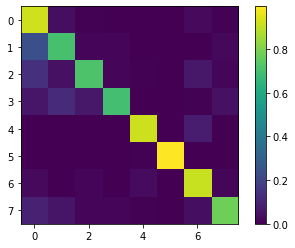

In [25]:
plt.imshow(conf_train)
plt.colorbar()

In [26]:
acc_valid, acc_class_valid, conf_valid, valid_y_pred, dens_cond_valid = get_accuracy(valid_x,valid_y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


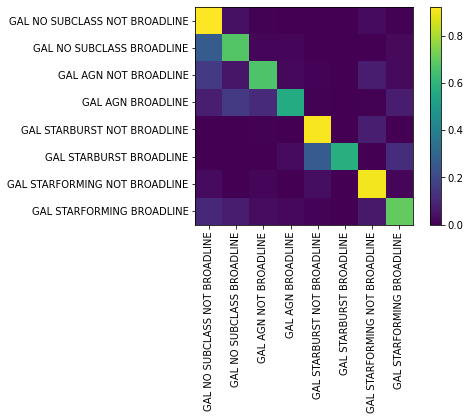

In [27]:
plt.imshow(conf_valid)
plt.xticks(ticks=np.arange(8), rotation=90, labels=[le[x] for x in range(8)])
plt.yticks(ticks=np.arange(8), rotation=0, labels=[le[x] for x in range(8)])
plt.colorbar()
plt.show()

In [28]:
print(acc_class_valid)
print(acc_valid)

[0.92249399 0.67500854 0.6470772  0.53677619 0.90872943 0.52439022
 0.90413159 0.69913274 0.63716817 0.74081236 0.75       0.58064514
 0.41269842 0.74812031 0.3888889  0.67567569]
[tensor(0.8683), 0.9748925809223719, 0.9928673732454883]


0
1
2
3
4
5
6
7
8
9
10


/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/v/vboehm/.conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value

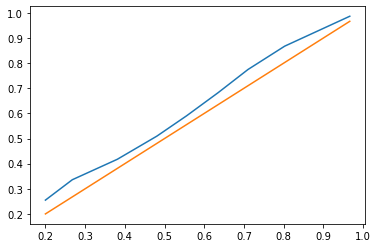

In [29]:
bins= np.linspace(0,1.,12)
accs     = []
pred_acc = []
prob_max = np.exp(np.amax(dens_cond_valid.cpu().numpy(),axis=0))/np.sum(np.exp(dens_cond_valid.cpu().numpy()),axis=0)
for ii in range(len(bins)-1):
    print(ii)
    interval = (bins[ii], bins[ii+1])
    ind      = (interval[0]<prob_max)*(prob_max<=interval[1])
    pred_acc.append(np.mean(prob_max[ind]))
    accuracy = sklearn.metrics.accuracy_score(valid_y.cpu()[ind], valid_y_pred[ind])
    accs.append(accuracy)
    
plt.plot(accs,pred_acc)
plt.plot(accs,accs)

In [ ]:
### temperature scaling, conditional generation, do complete analysis for majority class, train on discriminative hinge loss
### training unconditional network on majority class as comparison